# Analyzing neuropil signals one experiment at a time 
* 10/9/23 setup
* 10/16/23 migrating to `sleep` repo and stripping of sima stuff
* 10/18/23 kinda works for a sinle mouse
* refactoring with dfof calculation
* 10/30/23 adding dfof calculation

In [1]:
import sys, os
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import scipy.signal as signal
from scipy.interpolate import interp1d

sys.path.append("/home/gergely/code/sleep/src")

from suite2p_class import Suite2p

from imaging_data_class import ImagingData
from eeg_class import eegData
from behavior_class import behaviorData
import dfof


def freq_calc(data: pd.Series, fs: int = 10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend="linear")
    return frequencies, psd

### initializations of necessary classes

In [2]:
mice = ["5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"]

In [3]:
mouse = ImagingData(mice[0])
mouse.mouse_id
s2p_folders = mouse.find_suite2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Searching for suite2p folders in /data2/gergely/invivo_DATA/sleep/5HT2afl05b_1
(0, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_Zstack_pento/TSeries-07072021-0833_MC_pento-002/TSeries-07072021-0833_MC_pento-002_Cycle00001_Element00001.sima/s2p/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_Zstack_pento/TSeries-07072021-0833_GC_pento-001/TSeries-07072021-0833_GC_pento-001_Cycle00001_Element00001.sima/s2p/suite2p')
(2, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_2/TSeries-07022021-0814_MC-002/TSeries-07022021-0814_MC-002_Cycle00001_Element00001.sima/suite2p')
(3, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_2/TSeries-07022021-0814-001/TSeries-07022021-0814-001_Cycle00001_Element00001.sima/suite2p')
(4, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_1/TSeries-07012021-0854_MCs_afternoon-002/TSeries-07012021-0854_MCs_afternoon-002_Cycle00001_Element00001.sima/suite2p')
(5, '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_1/TSeries-07012021-0854_MCs-001/TS

In [4]:
s2p_folder = s2p_folders[9]
sima_folder = os.path.dirname(s2p_folder)
sima_folder

'/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima'

In [5]:
file_name = join(sima_folder, "eeg", "velo_eeg.csv")
eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)

eeg_velo["mobile_immobile"] = behaviorData.define_immobility(eeg_velo["filtered velo"])
eeg_velo

,Frames,filtered velo,time,score,awake,NREM,REM,other,mobile_immobile
0,0,5.301109,0.1069,0,True,False,False,False,True
1,1,5.847988,0.2069,0,True,False,False,False,True
2,2,6.455920,0.3069,0,True,False,False,False,True
3,3,6.541979,0.4069,0,True,False,False,False,True
4,4,5.850099,0.5069,0,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...
35995,35995,12.848967,3599.6069,0,True,False,False,False,True
35996,35996,12.262883,3599.7069,0,True,False,False,False,True
35997,35997,11.540549,3599.8069,0,True,False,False,False,True
35998,35998,10.835926,3599.9069,0,True,False,False,False,True


In [6]:
df = eegData.brain_state_filter(
    velo_eeg_df=eeg_velo,
    states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
)
df

,awake_mobile,awake_immobile,NREM,REM,other
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
35995,True,False,False,False,False
35996,True,False,False,False,False
35997,True,False,False,False,False
35998,True,False,False,False,False


### Loading raw fluorescence data then calculating dfof

In [9]:
s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)
s2p_data = Suite2p(s2p_folder=s2p_folder)
s2p_data
cells = s2p_data.get_cells()
npil = s2p_data.get_npil()

In [12]:
cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)
npil_dfof = jia_calc_dfof.calculate(signal=npil)

Calculating slow trend


### Looking at only the NREM vs awake immobile periods

#### Cell signal NREM vs. Awake immobile

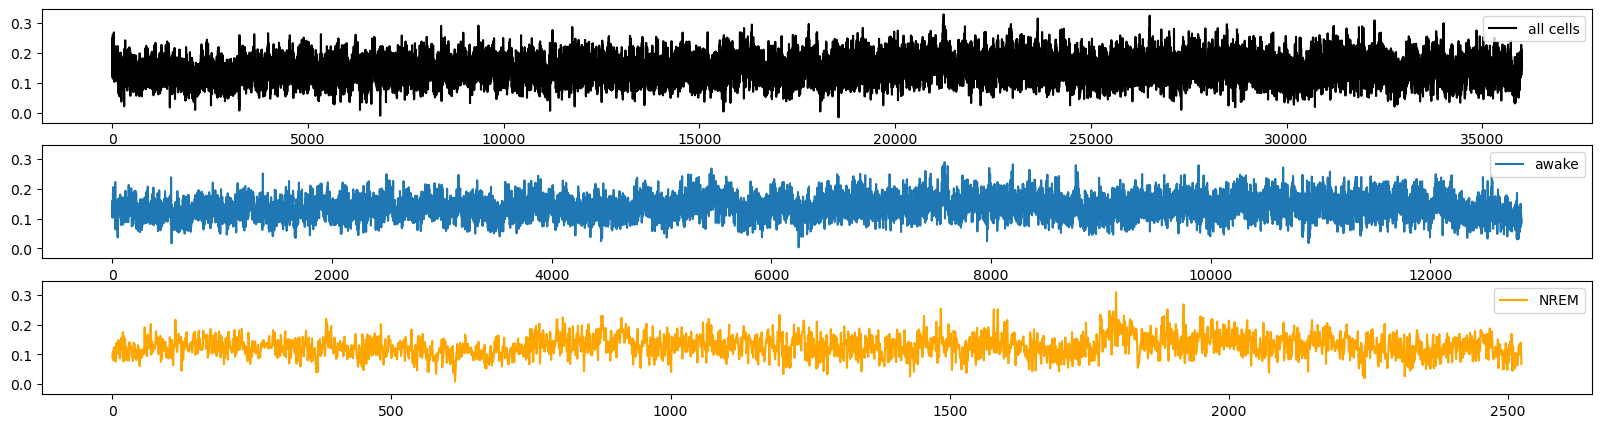

In [13]:
mean_cellF = cell_dfof.mean(axis=0)
fig, ax = plt.subplots(nrows=3, figsize=(20, 5), sharey=True)
# concatentate the True values:
ax[0].plot(mean_cellF.values, color="k", label="all cells")
ax[0].legend(loc="upper right", labelcolor="k")
ax[1].plot(mean_cellF[df["awake_immobile"]].values, label="awake")
ax[1].legend(loc="upper right", labelcolor="k")
ax[2].plot(mean_cellF[df["NREM"]].values, color="orange")
ax[2].legend(["NREM"], loc="upper right", labelcolor="k")
plt.show()
# fig.savefig(join(sima_folder, 'NREM Awake_immob Mean cell traces.png'),
#             bbox_inches='tight', dpi=300)

### Npil signal NREM vs. Awake immobile

#### NREM vs Awake immobile

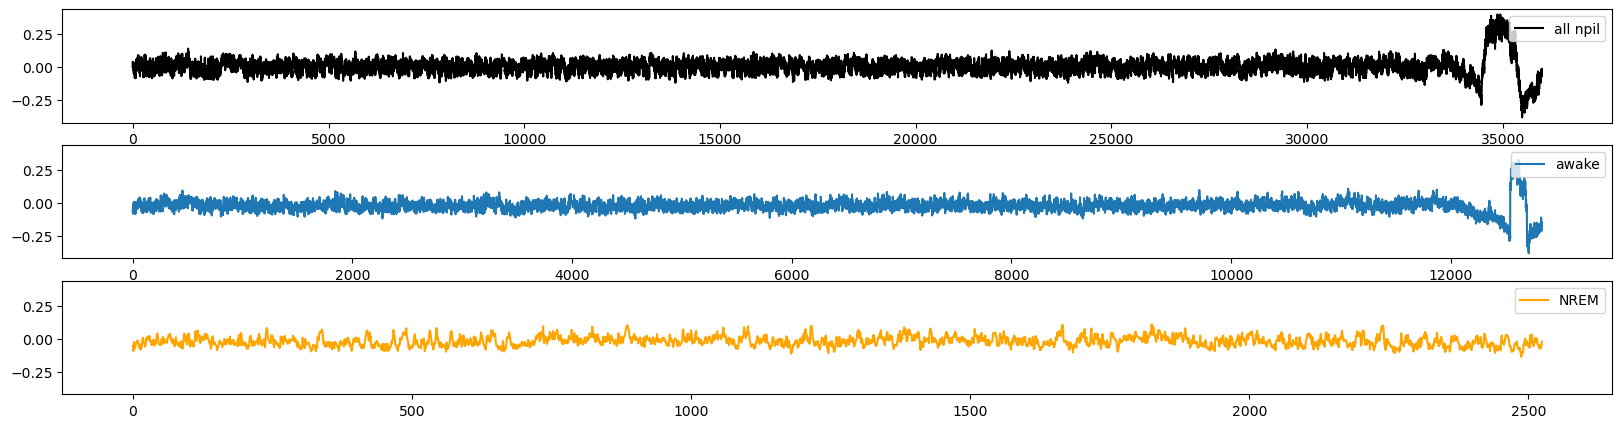

In [14]:
mean_npilF = npil_dfof.mean(axis=0)
fig, ax = plt.subplots(nrows=3, figsize=(20, 5), sharey=True)
ax[0].plot(mean_npilF.values, color="k")
ax[0].legend(["all npil"], loc="upper right", labelcolor="k")
ax[1].plot(mean_npilF[df["awake_immobile"]].values, label="awake")
ax[1].legend(labelcolor="k")
ax[1].legend(loc="upper right", labelcolor="k")
ax[2].plot(mean_npilF[df["NREM"]].values, color="orange", label="NREM")
ax[2].legend(["NREM"], loc="upper right", labelcolor="k")
plt.show()
# fig.savefig(
#     join(sima_folder, "NREM Awake_immob Mean npil traces.png"),
#     bbox_inches="tight",
#     dpi=300,
# )

### Calculations

In [15]:
input_data = {
    "nrem_cell": pd.Series(mean_cellF[df["NREM"]].values),
    "nrem_npil": pd.Series(mean_npilF[df["NREM"]].values),
    "awake_npil": pd.Series(mean_npilF[df["awake_immobile"]].values),
    "awake_cell": pd.Series(mean_cellF[df["awake_immobile"]].values),
}

In [16]:
results = {}

for key, value in input_data.items():
    freq, psd = freq_calc(value)
    results[key] = {"freq": freq, "psd": psd}

results.keys()

dict_keys(['nrem_cell', 'nrem_npil', 'awake_npil', 'awake_cell'])

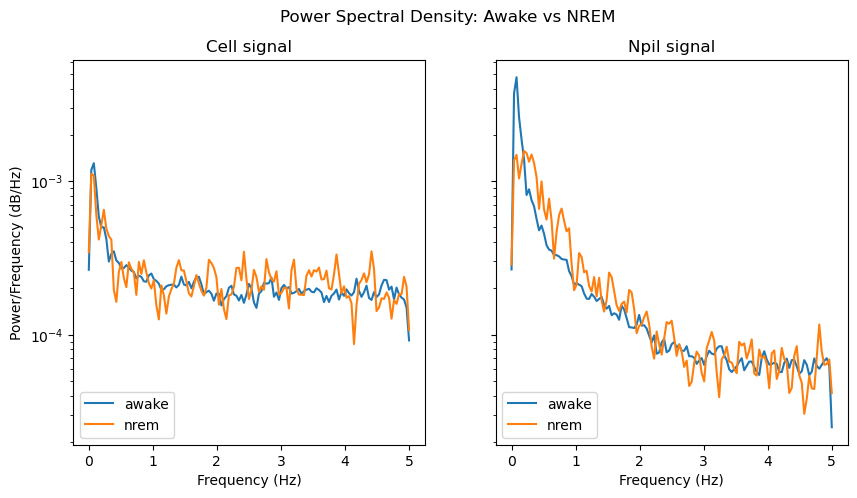

In [17]:
# Create a figure with 2 subplots in 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density: Awake vs NREM")

# Plot the first semilogy plot in the first subplot
axs[0].semilogy(
    results["awake_cell"]["freq"], results["awake_cell"]["psd"], label="awake"
)
axs[0].semilogy(results["nrem_cell"]["freq"], results["nrem_cell"]["psd"], label="nrem")
axs[0].legend(loc="lower left")

# Plot the second semilogy plot in the first subplot
axs[1].semilogy(
    results["awake_npil"]["freq"], results["awake_npil"]["psd"], label="awake"
)
axs[1].semilogy(results["nrem_npil"]["freq"], results["nrem_npil"]["psd"], label="nrem")
axs[1].legend(loc="lower left")

# Set the title and axis labels for the first subplot
axs[0].set_title("Cell signal")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Power/Frequency (dB/Hz)")

# Set the title and axis labels for the second subplot
axs[1].set_title("Npil signal")
axs[1].set_xlabel("Frequency (Hz)")

# Show the plot
plt.show()
# fig.savefig(join(sima_folder, 'PSD plot cell vs npil.png'),
#             bbox_inches='tight', dpi=300)

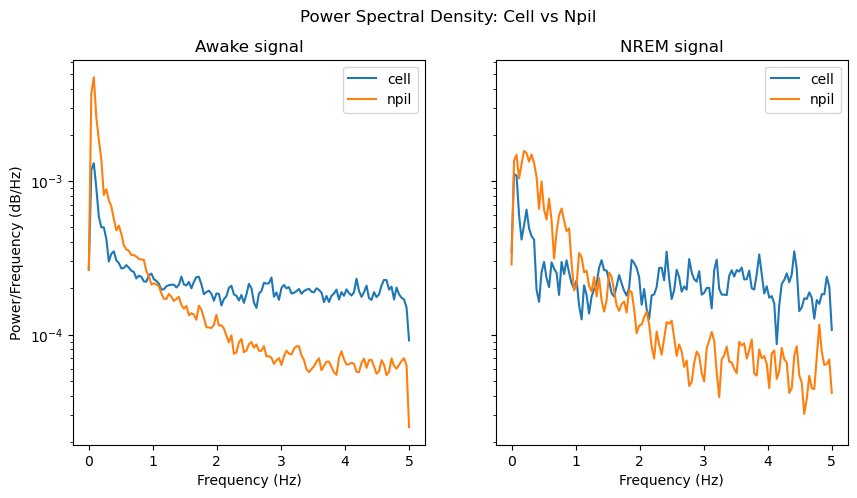

In [18]:
# Create a figure with 2 subplots in 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Power Spectral Density: Cell vs Npil")

# Plot the first semilogy plot in the first subplot
axs[0].semilogy(
    results["awake_cell"]["freq"], results["awake_cell"]["psd"], label="cell"
)
axs[0].semilogy(
    results["awake_npil"]["freq"], results["awake_npil"]["psd"], label="npil"
)
axs[0].legend()

# Plot the second semilogy plot in the first subplot
axs[1].semilogy(results["nrem_cell"]["freq"], results["nrem_cell"]["psd"], label="cell")
axs[1].semilogy(results["nrem_npil"]["freq"], results["nrem_npil"]["psd"], label="npil")
axs[1].legend()

# Set the title and axis labels for the first subplot
axs[0].set_title("Awake signal")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Power/Frequency (dB/Hz)")

# Set the title and axis labels for the second subplot
axs[1].set_title("NREM signal")
axs[1].set_xlabel("Frequency (Hz)")

# Show the plot
plt.show()
# fig.savefig(join(sima_folder, 'PSD plot awake vs NREM.png'),
#             bbox_inches='tight', dpi=300)

### Old-style calcs

### NREM vs non-NREM

In [ ]:
cells = s2p_mouse.true_signal(s2p_folder=s2p_folder)
# cells = s2p_mouse.true_cells(s2p_folder)
mean_cellF = pd.DataFrame(cells.mean(axis=0))
mean_cellF
fig, ax = plt.subplots(nrows=2, figsize=(20, 5))
ax[0].plot(
    signal.detrend(mean_cellF[~df["NREM"]], axis=0, type="linear"),
    color="orange",
    label="awake",
)
ax[0].legend(loc="upper right", labelcolor="k")
ax[1].plot(signal.detrend(mean_cellF[df["NREM"]], axis=0, type="linear"))
ax[1].legend(["NREM"], loc="upper right", labelcolor="k")
plt.show()
# fig.savefig(join(sima_folder, 'NREM Awake Mean cell traces.png'),
#             bbox_inches='tight', dpi=300)

### NREM vs. non-NREM

In [ ]:
cells = s2p_mouse.true_signal(s2p_folder=s2p_folder, signal_source="Fneu")
mean_npilF = pd.DataFrame(cells.mean(axis=0))
mean_npilF
fig, ax = plt.subplots(nrows=2, figsize=(20, 5))
ax[0].plot(
    signal.detrend(mean_npilF[~df["NREM"]], axis=0, type="linear"),
    color="orange",
    label="awake",
)
ax[0].legend(loc="upper right", labelcolor="k")
ax[0].legend(labelcolor="k")
ax[1].plot(signal.detrend(mean_npilF[df["NREM"]], axis=0, type="linear"), label="NREM")
ax[1].legend(["NREM"], loc="upper right", labelcolor="k")
plt.show()
fig.savefig(
    join(sima_folder, "NREM Awake Mean npil traces.png"), bbox_inches="tight", dpi=300
)